In [1]:
import xarray as xr
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
#import rioxarray as rxr
import torch
from matplotlib import colors

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
import torchvision
import pytorch_lightning as pl
import torch.nn.functional as F
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
import cv2
from torchvision.transforms import CenterCrop
# roc curve and auc
from sklearn import metrics 
from sklearn.metrics import roc_curve

from sklearn.metrics import roc_auc_score
transform = CenterCrop(128)

# ROC-Curves

In [9]:
unet_fpr= np.load("UNet1dim/input4_version1_onlycloud_def_lr/savedTensors/lr_fpr.npy")
unet_tpr= np.load("UNet1dim/input4_version1_onlycloud_def_lr/savedTensors/lr_tpr.npy")
unetcbam_fpr= np.load("UNet1dim_CBAM/input4_version1_onlycloud_0001_lr/savedTensors/lr_fpr.npy")
unetcbam_tpr= np.load("UNet1dim_CBAM/input4_version1_onlycloud_0001_lr/savedTensors/lr_tpr.npy")

ns_fpr = np.load("UNet1dim/input4_version1_onlycloud_def_lr/savedTensors/ns_fpr.npy")
ns_tpr= np.load("UNet1dim/input4_version1_onlycloud_def_lr/savedTensors/ns_tpr.npy")

unetcbam_fpr= np.load("UNet1dim_CBAM/input4_version1_onlycloud_0001_lr/savedTensors/lr_fpr.npy")
unetcbam_tpr= np.load("UNet1dim_CBAM/input4_version1_onlycloud_0001_lr/savedTensors/lr_tpr.npy")


co_fpr= np.load("ConvLSTM_CNN_skip/input4_version1_onlycloud_skip_CNN_0001/savedTensors/lr_fpr.npy")
co_tpr= np.load("ConvLSTM_CNN_skip/input4_version1_onlycloud_skip_CNN_0001/savedTensors/lr_tpr.npy")

met_fpr0 =np.load("MetNetFix/input4_version1_0001_001_reg/savedTensors/lr_fpr_0.npy")#.cpu()
met_tpr0 =np.load("MetNetFix/input4_version1_0001_001_reg/savedTensors/lr_tpr_0.npy")#.cpu()
met_fpr1 =np.load("MetNetFix/input4_version1_0001_001_reg/savedTensors/lr_fpr_1.npy")#.cpu()
met_tpr1 =np.load("MetNetFix/input4_version1_0001_001_reg/savedTensors/lr_tpr_1.npy")#.cpu()
met_fpr2 =np.load("MetNetFix/input4_version1_0001_001_reg/savedTensors/lr_fpr_2.npy")#.cpu()
met_tpr2 =np.load("MetNetFix/input4_version1_0001_001_reg/savedTensors/lr_tpr_2.npy")#.cpu()
met_fpr3 =np.load("MetNetFix/input4_version1_0001_001_reg/savedTensors/lr_fpr_3.npy")#.cpu()
met_tpr3 =np.load("MetNetFix/input4_version1_0001_001_reg/savedTensors/lr_tpr_3.npy")#.cpu()
met_fpr4 =np.load("MetNetFix/input4_version1_0001_001_reg/savedTensors/lr_fpr_4.npy")#.cpu()
met_tpr4 =np.load("MetNetFix/input4_version1_0001_001_reg/savedTensors/lr_tpr_4.npy")#.cpu()
met_fpr5 =np.load("MetNetFix/input4_version1_0001_001_reg/savedTensors/lr_fpr_5.npy")#.cpu()
met_tpr5 =np.load("MetNetFix/input4_version1_0001_001_reg/savedTensors/lr_tpr_5.npy")#.cpu()

per_fpr= np.load("persistenceroc/lr_fpr.npy")
per_tpr= np.load("persistenceroc/lr_tpr.npy")

op_fpr= np.load("opticalroc/lr_fpr.npy")
op_tpr= np.load("opticalroc/lr_tpr.npy")

In [8]:
per_fpr.shape

(3,)

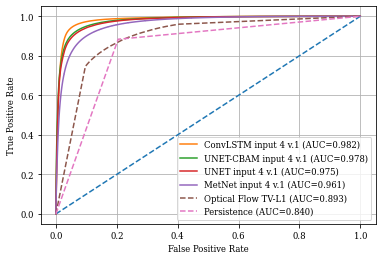

In [12]:
# calculate roc curves
#ns_fpr, ns_tpr, _ = roc_curve(target.flatten(), ns_probs)
#co_fpr, co_tpr, _ = roc_curve(target.flatten(), ConvLSTMI4V1.flatten())
#unetcbam_fpr, unetcbam_tpr, _ = roc_curve(target.flatten(), UNETCBAMI4V1.flatten())
#unet_fpr, unet_tpr, _ = roc_curve(target.flatten(), unet.flatten())

#unet_fpr= np.load("UNet1dim_CBAM/input4_version1_onlycloud_0001_lr/savedTensors/lr_fpr.npy")
# plot the roc curve for the model

#plt.rc('text', usetex=True)
plt.rc('font', family='DejaVu serif')
plt.rc('font', size = 8.5)
plt.plot(ns_fpr, ns_tpr, linestyle='--')#, label='No Skill')
plt.plot(co_fpr, co_tpr,  label='ConvLSTM input 4 v.1 (AUC=0.982)')
plt.plot(unetcbam_fpr, unetcbam_tpr,  label='UNET-CBAM input 4 v.1 (AUC=0.978)')
plt.plot(unet_fpr, unet_tpr,  label='UNET input 4 v.1 (AUC=0.975)')
plt.plot(met_fpr3, met_tpr3,  label='MetNet input 4 v.1 (AUC=0.961)')
plt.plot(op_fpr, op_tpr, linestyle='--',  label='Optical Flow TV-L1 (AUC=0.893)')
plt.plot(per_fpr, per_tpr, linestyle='--',  label='Persistence (AUC=0.840)')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.grid()
# show the plot

plt.savefig("roccurve.pdf")
plt.show()

# Falsepositive, truepositive, false negative, true negative plot

In [2]:
input_ = torch.load("ConvLSTM_CNN_skip/input4_version1_onlycloud_skip_CNN_0001/savedTensors/Input_batch7.pt")#.cpu()
out1 = torch.load("ConvLSTM_CNN_skip/input4_version1_onlycloud_skip_CNN_0001/savedTensors/Output_batch7.pt")#.cpu()
target=torch.load("ConvLSTM_CNN_skip/input4_version1_onlycloud_skip_CNN_0001/savedTensors/Target_batch7.pt")#.cpu()
input_ = torch.load("UNet1dim_CBAM/input4_version1_onlycloud_0001_lr/savedTensors/Input_batch7.pt")#.cpu()
out2 = torch.load("UNet1dim_CBAM/input4_version1_onlycloud_0001_lr/savedTensors/Output_batch7.pt")#.cpu()

unet = torch.load("UNet1dim/input4_version1_onlycloud_def_lr/savedTensors/Output_batch7.pt")#.cpu()

metnet0 =torch.load("MetNetFix/input4_version1_0001_001_reg/savedTensors/Output_batch15_0.pt")#.cpu()
metnet1 =torch.load("MetNetFix/input4_version1_0001_001_reg/savedTensors/Output_batch15_1.pt")#.cpu()
metnet2 =torch.load("MetNetFix/input4_version1_0001_001_reg/savedTensors/Output_batch15_2.pt")#.cpu()
metnet3 =torch.load("MetNetFix/input4_version1_0001_001_reg/savedTensors/Output_batch15_3.pt")#.cpu()
metnet4 =torch.load("MetNetFix/input4_version1_0001_001_reg/savedTensors/Output_batch15_4.pt")#.cpu()
metnet5 =torch.load("MetNetFix/input4_version1_0001_001_reg/savedTensors/Output_batch15_5.pt")#.cpu()


metnet=torch.cat((metnet0,metnet1 , metnet2, metnet3, metnet4, metnet5), 2)
#target2=torch.load("ConvLSTM_CNN_skip/input4_version1_onlycloud_skip_CNN_0001/savedTensors/Target_batch7.pt")#.cpu()

In [4]:
metnet.shape

torch.Size([2, 1, 6, 128, 128])

# ConvLSTM

In [3]:
out1[out1 < 0.5] = 0
out1[out1 >= 0.5] = 1
target[target < 0.5] = 0
target[target >= 0.5] = 1

In [4]:
fp=target-out1
fp[fp>-0.5]=0
fp[fp<-0.5]=-1
fn =out1-target
fn[fn>-0.5]=0
fn[fn<-0.5]=-2
tp =target*out1
tn = (target+out1)*-1
tn[tn>-0.5]=2
tn[tn<-0.5]=0

In [5]:
plot=tp+tn+fp+fn
plot[plot>1.5]=0
convlstm=plot

# UnetCBAM

In [6]:
out2[out2 < 0.5] = 0
out2[out2 >= 0.5] = 1
fp=target-out2
fp[fp>-0.5]=0
fp[fp<-0.5]=-1
fn =out2-target
fn[fn>-0.5]=0
fn[fn<-0.5]=-2
tp =target*out2
tn = (target+out2)*-1
tn[tn>-0.5]=2
tn[tn<-0.5]=0

In [7]:
Unetcbam=tp+tn+fp+fn
Unetcbam[Unetcbam>1.5]=0

# UNet

In [8]:
unet[unet < 0.5] = 0
unet[unet >= 0.5] = 1
fp=target-unet
fp[fp>-0.5]=0
fp[fp<-0.5]=-1
fn =unet-target
fn[fn>-0.5]=0
fn[fn<-0.5]=-2
tp =target*unet
tn = (target+unet)*-1
tn[tn>-0.5]=2
tn[tn<-0.5]=0

In [9]:
Unet=tp+tn+fp+fn
Unet[Unet>1.5]=0

# Metnet

In [10]:


metnet[metnet < 0.5] = 0
metnet[metnet >= 0.5] = 1
fp=target[:2,]-metnet
fp[fp>-0.5]=0
fp[fp<-0.5]=-1
fn =metnet-target[2:,]
fn[fn>-0.5]=0
fn[fn<-0.5]=-2
tp =target[2:,]*metnet
tn = (target[2:,]+metnet)*-1
tn[tn>-0.5]=2
tn[tn<-0.5]=0

In [11]:
plot=tp+tn+fp+fn
plot[plot>1.5]=0
MetNet1=plot

In [12]:
MetNet1.shape

torch.Size([2, 1, 6, 128, 128])

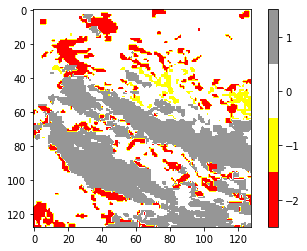

In [13]:

cmap = colors.ListedColormap(['red', 'yellow', (0,0,0,0), (150/255,150/255,150/255,1)])
img=plt.imshow(MetNet1[1,:,5].type(torch.float32).cpu().squeeze(), cmap=cmap)
bounds=[-2.5, -1.5,-0.5 ,0.5,1.5]
norm = colors.BoundaryNorm(bounds, cmap.N)
plt.colorbar(img, boundaries=bounds, ticks=[-2, -1,0,1,2])
#bar.ax.set_yticklabels(labels)

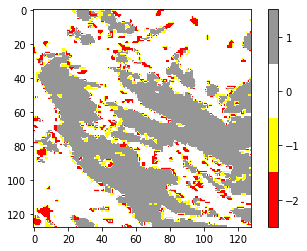

In [14]:

cmap = colors.ListedColormap(['red', 'yellow', (0,0,0,0), (150/255,150/255,150/255,1)])
img=plt.imshow(convlstm[3,:,1].type(torch.float32).cpu().squeeze(), cmap=cmap)
bounds=[-2.5, -1.5,-0.5 ,0.5,1.5]
norm = colors.BoundaryNorm(bounds, cmap.N)
plt.colorbar(img, boundaries=bounds, ticks=[-2, -1,0,1,2])
#bar.ax.set_yticklabels(labels)

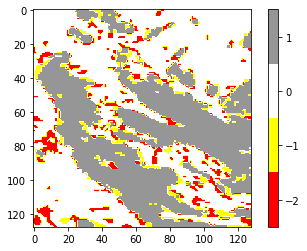

In [15]:

cmap = colors.ListedColormap(['red', 'yellow', (0,0,0,0), (150/255,150/255,150/255,1)])
cmap1 = colors.ListedColormap([ (0,0,0,0), (150/255,150/255,150/255,1)])
img=plt.imshow(Unetcbam[3,:,1].type(torch.float32).cpu().squeeze(), cmap=cmap)
bounds=[-2.5, -1.5,-0.5 ,0.5,1.5]
norm = colors.BoundaryNorm(bounds, cmap.N)
plt.colorbar(img, boundaries=bounds, ticks=[-2, -1,0,1,2])
#bar.ax.set_yticklabels(labels)

# laver map i baggrunden


In [16]:
file = './data/Data2021/2021_09_01/S_NWC_CMA_MSG4_globeM-VISIR_20210901T000000Z_4dcc7a6a8c7eaf55c00bbb2884fc3057.nc'
files = os.listdir('./data/Data2021/2021_09_01')
rand_file_idx = np.random.randint(97)
rand_file = "./data/Data2021/2021_09_01/" + files[rand_file_idx]

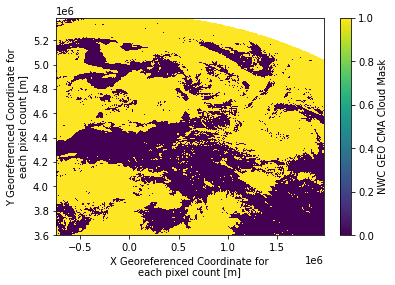

In [17]:
dat =  xr.open_dataset(rand_file, engine="h5netcdf", decode_cf = True)
#dat1 = rxr.open_rasterio(rand_file)
dat.cma.plot()

In [18]:
output_area = dat.cma[140+64:396-64,342+64:598-64]

In [20]:
# Making a copy of the opened satellite image
geo_output01 = output_area.copy()
geo_output02 = output_area.copy()
geo_output03 = output_area.copy()
geo_output04 = output_area.copy()
geo_output05 = output_area.copy()
geo_output06 = output_area.copy()
geo_output1 = output_area.copy()
geo_output2 = output_area.copy()
geo_output3 = output_area.copy()
geo_output4 = output_area.copy()
geo_output5 = output_area.copy()
geo_output6 = output_area.copy()
geo_output7 = output_area.copy()
geo_output8 = output_area.copy()
geo_output9 = output_area.copy()
geo_output10 = output_area.copy()
geo_output11 = output_area.copy()
geo_output12 = output_area.copy()
geo_output13 = output_area.copy()
geo_output14 = output_area.copy()
geo_output15 = output_area.copy()
geo_output16 = output_area.copy()
geo_output17 = output_area.copy()
geo_output18 = output_area.copy()
geo_output19 = output_area.copy()
geo_output20 = output_area.copy()
geo_output21 = output_area.copy()
geo_output22 = output_area.copy()
geo_output23 = output_area.copy()
geo_output24 = output_area.copy()



geo_output01.data = target[3,:,0].type(torch.float32).cpu().squeeze()
geo_output02.data = target[3,:,1].type(torch.float32).cpu().squeeze()
geo_output03.data = target[3,:,2].type(torch.float32).cpu().squeeze()
geo_output04.data = target[3,:,3].type(torch.float32).cpu().squeeze()
geo_output05.data = target[3,:,4].type(torch.float32).cpu().squeeze()
geo_output06.data = target[3,:,5].type(torch.float32).cpu().squeeze()
geo_output1.data = convlstm[3,:,0].type(torch.float32).cpu().squeeze()
geo_output2.data = convlstm[3,:,1].type(torch.float32).cpu().squeeze()
geo_output3.data = convlstm[3,:,2].type(torch.float32).cpu().squeeze()
geo_output4.data = convlstm[3,:,3].type(torch.float32).cpu().squeeze()
geo_output5.data = convlstm[3,:,4].type(torch.float32).cpu().squeeze()
geo_output6.data = convlstm[3,:,5].type(torch.float32).cpu().squeeze()
geo_output7.data = Unetcbam[3,:,0].type(torch.float32).cpu().squeeze()
geo_output8.data = Unetcbam[3,:,1].type(torch.float32).cpu().squeeze()
geo_output9.data = Unetcbam[3,:,2].type(torch.float32).cpu().squeeze()
geo_output10.data = Unetcbam[3,:,3].type(torch.float32).cpu().squeeze()
geo_output11.data = Unetcbam[3,:,4].type(torch.float32).cpu().squeeze()
geo_output12.data = Unetcbam[3,:,5].type(torch.float32).cpu().squeeze()
geo_output13.data = Unet[3,:,0].type(torch.float32).cpu().squeeze()
geo_output14.data = Unet[3,:,1].type(torch.float32).cpu().squeeze()
geo_output15.data = Unet[3,:,2].type(torch.float32).cpu().squeeze()
geo_output16.data = Unet[3,:,3].type(torch.float32).cpu().squeeze()
geo_output17.data = Unet[3,:,4].type(torch.float32).cpu().squeeze()
geo_output18.data = Unet[3,:,5].type(torch.float32).cpu().squeeze()
geo_output19.data = MetNet1[1,:,0].type(torch.float32).cpu().squeeze()
geo_output20.data = MetNet1[1,:,1].type(torch.float32).cpu().squeeze()
geo_output21.data = MetNet1[1,:,2].type(torch.float32).cpu().squeeze()
geo_output22.data = MetNet1[1,:,3].type(torch.float32).cpu().squeeze()
geo_output23.data = MetNet1[1,:,4].type(torch.float32).cpu().squeeze()
geo_output24.data = MetNet1[1,:,5].type(torch.float32).cpu().squeeze()


In [21]:
plotframes= [geo_output01, geo_output02,geo_output03,geo_output04,geo_output05,geo_output06,geo_output1, geo_output2,geo_output3,geo_output4,geo_output5,geo_output6,geo_output7, geo_output8,geo_output9,geo_output10,geo_output11,geo_output12,geo_output13,geo_output14, geo_output15,geo_output16,geo_output17,geo_output18,geo_output19,geo_output20,geo_output21,geo_output22,geo_output23,geo_output24]

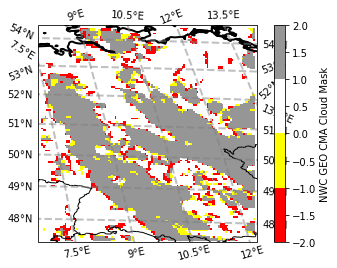

In [22]:
data_proj = ccrs.Geostationary(central_longitude=0, 
    satellite_height=35785863.00, sweep_axis="y", globe=ccrs.Globe())
map_proj = data_proj
ax = plt.axes(projection=map_proj)
ax.set_extent([7.76, 12.2, 47.45, 54.5], crs=ccrs.PlateCarree()) # (ind fra venstre, ind fra højre, højde nedefra, højde oppefra)
#ax.stock_img()
#ax.set_extent([4.5, 14.8, 44, 59], crs=ccrs.PlateCarree()) # (ind fra venstre, ind fra højre, højde nedefra, højde oppefra)
ax.add_feature(cf.COASTLINE, lw=2)
ax.add_feature(cf.BORDERS)
geo_output1.plot(transform = data_proj, cmap=cmap)
plt.scatter(x = 5.278151413236939, y = 58.62858511635695, color="red", s=80, transform = ccrs.PlateCarree()) #Top-left corner
plt.scatter(x = 3.715224194668945, y = 44.285549828485195, color="red", s=80, transform = ccrs.PlateCarree()) # Bottom-left corner
plt.scatter(x = 14.036919170158745, y = 44.52281739161824, color="red", s=80, transform = ccrs.PlateCarree()) # Bottom-right corner
plt.scatter(x = 20.518835840591922, y = 59.28848849319079, color="red", s=80, transform = ccrs.PlateCarree()) # Top-right
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

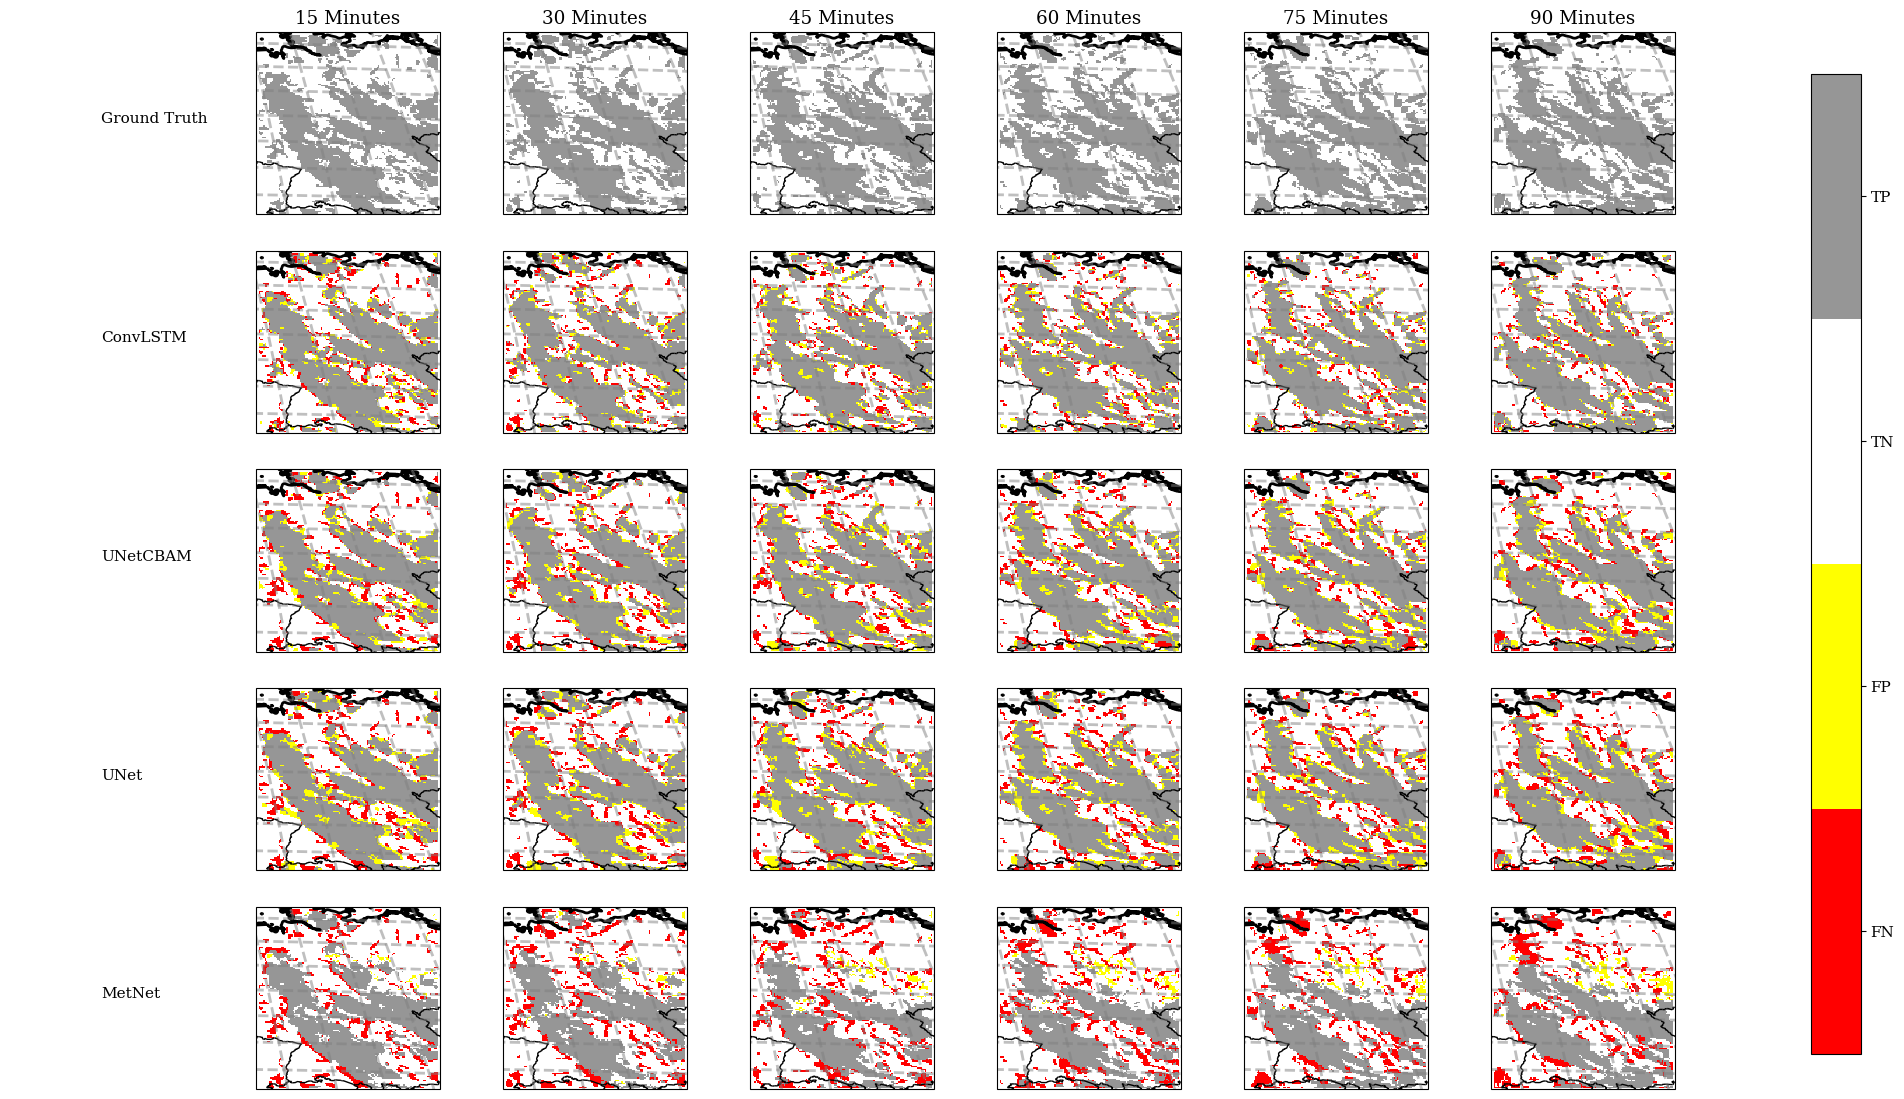

In [23]:
#plt.rc('text', usetex=True)
plt.rc('font', family='DejaVu serif')
plt.rc('font', size = 11)

fig, axis = plt.subplots(5,7, figsize=(25,14), dpi=100, subplot_kw=dict(projection=map_proj))

for i,ax in enumerate(axis.flatten()):

    if i==0:
        ax.set_axis_off()
        ax.text(0.5,0.5, "Ground Truth")
    elif i==7:
        ax.set_axis_off()
        ax.text(0.5,0.5, "ConvLSTM")
    elif i==14:
        ax.set_axis_off()
        ax.text(0.5,0.5, "UNetCBAM")
    elif i==21:
        ax.set_axis_off()
        ax.text(0.5,0.5, "UNet")
    elif i==28:
        ax.set_axis_off()
        ax.text(0.5,0.5, "MetNet")
    elif i<=6:   
        ax.add_feature(cf.COASTLINE, lw=2)
        ax.add_feature(cf.BORDERS)
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
        ax.set_extent([7.76, 12.2, 47.45, 54.5], crs=ccrs.PlateCarree()) # (ind fra venstre, ind fra højre, højde nedefra, højde oppefra)
       # ax.stock_img()
        im1 = plotframes[i-1].plot(transform = data_proj, cmap=cmap1, add_colorbar=False, ax = ax)
        ax.set_title('{time} Minutes'.format(time = (i)*15))
    elif i<=13:
        ax.add_feature(cf.COASTLINE, lw=2)
        ax.add_feature(cf.BORDERS)
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
        ax.set_extent([7.76, 12.2, 47.45, 54.5], crs=ccrs.PlateCarree()) # (ind fra venstre, ind fra højre, højde nedefra, højde oppefra)
        #ax.stock_img()
        im2 = plotframes[i-2].plot(transform = data_proj, cmap=cmap, add_colorbar=False, ax = ax)
       # ax.set_title('{time} Minutes in future'.format(time = (i-6-1)*15))
    elif i<=20:
        ax.add_feature(cf.COASTLINE, lw=2)
        ax.add_feature(cf.BORDERS)
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
        ax.set_extent([7.76, 12.2, 47.45, 54.5], crs=ccrs.PlateCarree()) # (ind fra venstre, ind fra højre, højde nedefra, højde oppefra)
        #ax.stock_img()
        im2 = plotframes[i-3].plot(transform = data_proj, cmap=cmap, add_colorbar=False, ax = ax)
      #  ax.set_title('{time} Minutes in future'.format(time = (i-6-1)*15))
    elif i<=27:
        ax.add_feature(cf.COASTLINE, lw=2)
        ax.add_feature(cf.BORDERS)
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
        ax.set_extent([7.76, 12.2, 47.45, 54.5], crs=ccrs.PlateCarree()) # (ind fra venstre, ind fra højre, højde nedefra, højde oppefra)
        #ax.stock_img()
        im2 = plotframes[i-4].plot(transform = data_proj, cmap=cmap, add_colorbar=False, ax = ax)
      #  ax.set_title('{time} Minutes in future'.format(time = (i-6-1)*15))
    else:
        ax.add_feature(cf.COASTLINE, lw=2)
        ax.add_feature(cf.BORDERS)
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
        ax.set_extent([7.76, 12.2, 47.45, 54.5], crs=ccrs.PlateCarree()) # (ind fra venstre, ind fra højre, højde nedefra, højde oppefra)
        #ax.stock_img()
        im2 = plotframes[i-5].plot(transform = data_proj, cmap=cmap, add_colorbar=False, ax = ax)
        #ax.set_title('{time} Minutes in future'.format(time = (i-27)*15))
    
        
   
fig.subplots_adjust(right=.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7]) #Adjustment from right, adjustment from top, width of CB, height of CB
cbar=fig.colorbar(im2, cax=cbar_ax, boundaries=[-2.5, -1.5,-0.5 ,0.5,1.5], ticks=[-2, -1,0,1,2])
cbar.ax.set_yticklabels(["FN", "FP", "TN", "TP"])
fig.savefig("falseposiveplot.pdf")
fig.show()